In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

### Tanh을 구현해봅시다.

In [3]:
class Tanh(Model):
    def call(self, x):
        return 2 / (1 + tf.exp(-2*x)) - 1

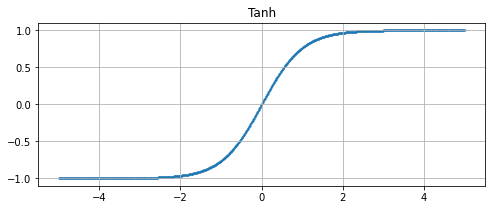

In [4]:
x = tf.linspace(-5, 5, 1000)
y = Tanh()(x)

plt.figure(figsize=[8, 3])
plt.title('Tanh')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

### Dense Layer를 구현해봅시다.

In [5]:
class Dense(Model): 
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.w = tf.random.normal(shape=(input_dim, output_dim))
        self.b = tf.zeros(shape=(output_dim))
        
    def call(self, x):
        # (batch, input_dim)
        # y = W*x + b
        y = x @ self.w + self.b
        return y

In [6]:
t = tf.random.normal((2, 256)) # x
t = Dense(256, 512)(t)
print(t.shape)

(2, 512)


### RNNCell을 구현해봅시다.
$h^{\prime}=\tanh \left(W_{i h} x+b_{i h}+W_{h h} h+b_{h h}\right)$

In [7]:
class RNNCell(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.dense_1 = Dense(hidden_dim, hidden_dim)
        self.dense_2 = Dense(input_dim, hidden_dim)
        self.activation = activation()       
    
    def call(self, x, h):
        # x : (batch, input_dim)
        h = self.activation(self.dense_2(x)+self.dense_1(h))
        return h

In [8]:
x = tf.random.normal((2, 100, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = RNNCell(16, 32)(x,h)
print(y.shape)

(2, 32)


### RNN을 구현해봅시다.

RNN는 RNNCell을 sub-layer로 갖고 있습니다.

forward pass를 구현하는 call에서 for loop 통해 매 time step의 vector를 RNNCell에 넣고 hidden state를 출력합니다.

출력된 hidden state는 다음 time step의 hidden state 입력으로 들어갑니다.

첫번째 time step에서는 주어진 hidden state가 없으므로 tf.zeros를 이용하여 0으로 채운 벡터를 사용합니다.

모든 time step의 출력은 for loop이 끝난 뒤, tf.stack 명령을 통해 쌓아서 최종 출력으로 만듭니다.

In [9]:
class RNN(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = RNNCell(input_dim, hidden_dim, activation)
    
    def call(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화한다.
        y = [] # 결과를 저장할 곳을 초기화 (빈 리스트)
        for l in range(length): # timestep으로 loop
            # batch, length, input_dim
            x_ = x[:, l, :]
            h = self.rnn_cell(x_, h)
            y.append(h)
        y = tf.stack(y, axis=1)
        return y       
    

In [10]:
x = tf.random.normal((2, 100, 16))
y = RNN(16, 32)(x)
print(y.shape)

(2, 100, 32)


In [12]:
class Sigmoid(Model):
    def call(self, x):
        return 1 / (1 + np.exp(-x))

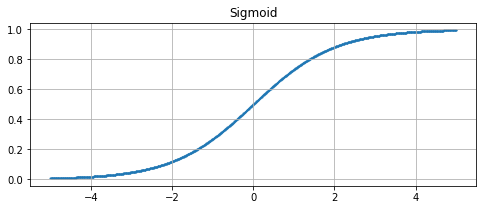

In [15]:
x = tf.linspace(-5, 5, 1000)
y = Sigmoid()(x)

plt.figure(figsize=[8, 3])
plt.title('Sigmoid')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

### GRUCell을 구현해봅시다.

\begin{aligned}
&r=\sigma\left(W_{i r} x+b_{i r}+W_{h r} h+b_{h r}\right) \\
&z=\sigma\left(W_{i z} x+b_{i z}+W_{h z} h+b_{h z}\right) \\
&n=\tanh \left(W_{i n} x+b_{i n}+r *\left(W_{h n} h+b_{h n}\right)\right) \\
&h^{\prime}=(1-z) * n+z * h
\end{aligned}

In [17]:
class GRUCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense_ir = Dense(input_dim, hidden_dim)
        self.dense_hr = Dense(hidden_dim, hidden_dim)
        self.dense_iz = Dense(input_dim, hidden_dim)
        self.dense_hz = Dense(hidden_dim, hidden_dim)
        self.dense_in = Dense(input_dim, hidden_dim)
        self.dense_hn = Dense(hidden_dim, hidden_dim)

    def call(self, x, h):
        # x : (batch, input_dim)
        # h : (batch, hidden_dim)

        r = self.sigmoid(self.dense_ir(x) + self.dense_hr(h))
        z = self.sigmoid(self.dense_iz(x) + self.dense_hz(h))
        n = self.tanh(self.dense_in(x) + r* self.dense_hn(h))
        h = (1-z) * n + z *h
        return h
    

In [18]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = GRUCell(16, 32)(x,h)
print(y.shape)

(2, 32)


### GRU를 구현해봅시다.

In [19]:
class GRU(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim)
    
    def call(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화한다.
        y = [] # 결과를 저장할 곳을 초기화 (빈 리스트)
        for l in range(length): # timestep으로 loop
            # batch, length, input_dim
            x_ = x[:, l, :]
            h = self.gru_cell(x_, h)
            y.append(h)
        y = tf.stack(y, axis=1)
        return y  
            

In [20]:
x = tf.random.normal((2, 100, 16))
y = GRU(16, 32)(x)
print(y.shape)

(2, 100, 32)


### LSTM을 구현해봅시다.

\begin{aligned}
&i=\sigma\left(W_{i i} x+b_{i i}+W_{h i} h+b_{h i}\right) \\
&f=\sigma\left(W_{i f} x+b_{i f}+W_{h f} h+b_{h f}\right) \\
&g=\tanh \left(W_{i g} x+b_{i g}+W_{h g} h+b_{h g}\right) \\
&o=\sigma\left(W_{i o} x+b_{i o}+W_{h o} h+b_{h o}\right) \\
&c^{\prime}=f * c+i * g \\
&h^{\prime}=o * \tanh \left(c^{\prime}\right)
\end{aligned}

In [21]:
class LSTMCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense = Dense(input_dim + hidden_dim, hidden_dim*4)
    
    def call(self, x, state):
        # x : (batch, input_dim)
        # state : (batch, hidden_dim), (batch, hidden_dim)
        h, c = state

        # (batch, input_dim + hidden_dim)
        xh = np.concatenate([x, h], axis=1)

        # (batch , hidden_dim *4)
        d = self.dense(xh)

        # (batch, hidden_dim), (batch, hidden_dim), (batch, hidden_dim), (batch, hidden_dim)
        i, f, g, o = tf.split(d, 4, axis=1)

        i = self.sigmoid(i)
        f = self.sigmoid(f)
        g = self.tanh(g)
        o = self.sigmoid(o)
        c_ = f*c + i*g
        h_ = o*self.tanh(c_)

        return h_, c_
        

In [22]:
class LSTM:
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
    
    def __call__(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화한다.
        c = tf.zeros((batch, self.hidden_dim))
        y = [] # 결과를 저장할 곳을 초기화 (빈 리스트)
        for l in range(length): # timestep으로 loop
            # batch, length, input_dim
            x_ = x[:, l, :]
            h, c = self.lstm_cell(x_, (h,c))
            y.append(h)
        y = tf.stack(y, axis=1)
        return y 

In [23]:
x = tf.random.normal((2, 100, 16))
y = LSTM(16, 32)(x)
print(y.shape)

(2, 100, 32)


## RNN으로 소설 생성하기

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
print(path_to_file)

1130496/1115394 [==============================] - 0s 0us/step
/root/.keras/datasets/shakespeare.txt


In [3]:
line =' 하이 '
line.rstrip()

' 하이'

In [4]:
with open(path_to_file, 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line.rstrip())

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Page:
My lord, 'tis but begun.

SLY:
'Tis a very excellent piece of work, madam lady:
would 'twere done!

PETRUCHIO:
Verona, for a while I take my leave,
To see my friends in Padua, but of all
My best beloved and approved friend,
Hortensio; and I trow this is his house.
Here, sirrah Grumio; knock, I say.

GRUMIO:
Knock, sir! whom should I knock? is there man has
rebused your worship?

PETRUCHIO:
Villain, I say, knock me here soundly.

GRUMIO:
Knock you here, sir! why, sir, what am I, sir, that
I should knock you here, sir?

PETRUCHIO:
Villain, I say, knock me at this gate
And rap me well, or I'll knock your knave's pate.

GRUMIO:
My master is grown quarrelsome. I should knock
you first,
And then I know after who comes by the worst.

PETRUCHIO:
Will it not be?
Faith, sirrah, an you'll not knock, I'll ring it;
I'll try how you can sol, fa, and sing it.

GRUMIO:
Help, masters, help! my master is mad.

PETRUCHIO:
Now, knock when I bid you, sirrah villain

### 데이터 읽기

In [5]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print('텍스트의 길이 : {}자'.format(len(text)))

텍스트의 길이 : 1115394자


In [6]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [7]:
vocab = sorted(set(text)) #중복제거
print('고유 문자 수 {}개'.format(len(vocab)))

고유 문자 수 65개


### 텍스트 벡터화

In [8]:
for i, u in enumerate(vocab):
    print(i, u)

0 

1  
2 !
3 $
4 &
5 '
6 ,
7 -
8 .
9 3
10 :
11 ;
12 ?
13 A
14 B
15 C
16 D
17 E
18 F
19 G
20 H
21 I
22 J
23 K
24 L
25 M
26 N
27 O
28 P
29 Q
30 R
31 S
32 T
33 U
34 V
35 W
36 X
37 Y
38 Z
39 a
40 b
41 c
42 d
43 e
44 f
45 g
46 h
47 i
48 j
49 k
50 l
51 m
52 n
53 o
54 p
55 q
56 r
57 s
58 t
59 u
60 v
61 w
62 x
63 y
64 z


In [9]:
for c in text[:100]:
    print(c)

F
i
r
s
t
 
C
i
t
i
z
e
n
:


B
e
f
o
r
e
 
w
e
 
p
r
o
c
e
e
d
 
a
n
y
 
f
u
r
t
h
e
r
,
 
h
e
a
r
 
m
e
 
s
p
e
a
k
.




A
l
l
:


S
p
e
a
k
,
 
s
p
e
a
k
.




F
i
r
s
t
 
C
i
t
i
z
e
n
:


Y
o
u


In [10]:
# 고유 문자에서 인덱스로 매핑 생성
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [11]:
print(len(text_as_int))
print(text_as_int[:50])

1115394
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56]


In [12]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print(' {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print(' ...\n')

{
 '\n':   0,
 ' ' :   1,
 '!' :   2,
 '$' :   3,
 '&' :   4,
 "'" :   5,
 ',' :   6,
 '-' :   7,
 '.' :   8,
 '3' :   9,
 ':' :  10,
 ';' :  11,
 '?' :  12,
 'A' :  13,
 'B' :  14,
 'C' :  15,
 'D' :  16,
 'E' :  17,
 'F' :  18,
 'G' :  19,
 ...



In [13]:
# 텍스트에서 처음 13개의 문자가 숫자로 어떻게 매핑되었는지 봅시다.
print('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [14]:
len(text) % 101

51

In [15]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text) // seq_length

# 훈련 샘플/타킷 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #텍스트 벡터 -> 문자 인덱스 스트림으로 변환

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


In [16]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
# batch : 개별 문자들을 원하는 크기의 시퀀스로 쉽게 변환 할 수 있다.

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [17]:
string = 'First Citizen'
print(string[:-1])
print(string[1:])

First Citize
irst Citizen


In [18]:
def split_input_target(chunk):
    input_text = chunk[0:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
# map : 각 배치에 간단한 함수를 적용하고 입력 텍스트와 타깃 텍스트를 복사 및 이동합니다.

In [19]:
for input_example, target_example in dataset.take(1):
    print('입력 데이터 :', repr(''.join(idx2char[input_example.numpy()])))
    print('타깃 데이터 :', repr(''.join(idx2char[target_example.numpy()])))

입력 데이터 : 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
타깃 데이터 : 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [20]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("{:4d}단계".format(i))
    print(" 입력: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print(" 예상 출력: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

   0단계
 입력: 18 ('F')
 예상 출력: 47 ('i')
   1단계
 입력: 47 ('i')
 예상 출력: 56 ('r')
   2단계
 입력: 56 ('r')
 예상 출력: 57 ('s')
   3단계
 입력: 57 ('s')
 예상 출력: 58 ('t')
   4단계
 입력: 58 ('t')
 예상 출력: 1 (' ')


### 훈련 배치 생성

In [21]:
BATCH_SIZE = 64

# 데이터셋을 섞을 버퍼 크기
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### 모델 설계

In [22]:
class Embedding:
    def __init__(self, input_dim, output_dim):
        self.table = np.random.randn(input_dim, output_dim)
    def __call__(self, x):
        # x : (batch, length) int
        batch, length = x.shape
        x = x.flatten()
        # (batch * length. output_dim)
        y = self.table[x]
        # (batch, length, output_dim)
        y = y.reshape(batch, length, -1)
        return y

In [23]:
len(vocab)

65

In [24]:
x = np.random.randint(0, len(vocab), size=(3, 100))
embedding = Embedding(len(vocab), 512)
y = embedding(x)
print(y.shape)

(3, 100, 512)


In [25]:
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)
print(vocab_size)

# 임베딩 차원
embedding_dim = 256

# RNN 갯수
rnn_units = 1024

65


In [26]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                                 tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
                                 tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [28]:
model = build_model(vocab_size = len(vocab),
                   embedding_dim= embedding_dim,
                   rnn_units = rnn_units,
                   batch_size=BATCH_SIZE)

### 모델 사용

In [29]:
# 출력 형태 살펴보기
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (배치크기, 시퀀스 길이, 어휘 사전 크기)")

(64, 100, 65) # (배치크기, 시퀀스 길이, 어휘 사전 크기)


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           16640     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 배치의 첫 번째 샘플링
example_batch_predictions[0].shape

TensorShape([100, 65])

In [33]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
print(sampled_indices.shape)
sampled_indices= tf.squeeze(sampled_indices, axis=-1).numpy()
print(sampled_indices.shape)

(100, 1)
(100,)


In [34]:
sampled_indices

array([54,  4, 26, 58, 39, 18, 45,  6, 46, 58, 39, 38, 50, 17, 19, 16, 49,
       44,  8, 32, 20, 34, 42, 31, 58, 25, 43, 47, 63, 45, 11, 46, 42, 51,
        2, 24, 60,  2, 46, 29, 23, 63, 35, 38,  6, 13,  5,  2,  4,  7, 28,
       24, 53,  2, 12, 18, 19, 24, 19, 40, 25, 51, 12, 41, 54, 45, 26,  2,
       46, 61, 10, 32, 23, 62,  2, 56, 48, 64, 46, 54, 51, 13, 56,  6, 27,
       51, 38, 23,  9, 13,  4, 57, 12, 24, 13, 49, 22, 51, 23, 25])

In [35]:
print("입력 : \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("예측된 다음 문자: \n", repr("".join(idx2char[sampled_indices])))

입력 : 
 'of the house.\n\nThird Servant:\nWhy, sir, you know no house nor no such maid,\nNor no such men as you h'

예측된 다음 문자: 
 "p&NtaFg,htaZlEGDkf.THVdStMeiyg;hdm!Lv!hQKyWZ,A'!&-PLo!?FGLGbMm?cpgN!hw:TKx!rjzhpmAr,OmZK3A&s?LAkJmKM"


In [36]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [37]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("예측 배열 크기(shape) :", example_batch_predictions.shape) 
print("스칼라 손실 :", example_batch_loss.numpy().mean())

예측 배열 크기(shape) : (64, 100, 65)
스칼라 손실 : 4.173852


In [38]:
model.compile(optimizer = 'adam', loss = loss)

In [40]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'
# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [52]:
Epoch = 30
history = model.fit(dataset, epochs=Epoch, callbacks=[checkpoint_callback])

RuntimeError: ignored

In [42]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_10'

In [43]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [50]:
def generate_text(model, start_string):
    # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

    #생성할 문자의 수
    num_generate= 1000

    # 시작 문자열을 숫자로 변환(벡터화)
    input_eval = [char2idx[s] for s in start_string]
    # (1 len(start_string))
    input_eval = tf.expand_dims(input_eval, 0)

    #결과를 저장할 빈 문자열
    text_generated= []

    # 온도가 낮으면 더 에측 가능한 텍스트가 되고
    # 온도가 높으면 더 의외의 텍스트가 됩니다.
    # 최적의 세팅을 찾기 위한 실험
    temperature = 1.0

    # 여기에서 배치 크기 == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # 배치 차원 제거
        predictions = tf.squeeze(predictions, 0)

        #범주형 분포를 사용하여 모델에서 리턴한 단어 예측
        predictions = predictions/ temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # 예측된 단어를 다음 입력으로 모델에 전달
        # 이전 은닉 상태와 함께
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [51]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: BALUSNTFBzARCAMY:
Not both your hands and mons of tale!

DUCHESS OF YORK:
To closen cry has been proud most stretgh
There let me pass. Downow your right?

PETRUCHIO:
Now, by the followers, stronger!

DUKE VINCENTIO:
No, master yield, with your butterfish shall,
Since God! this interrupted man,
Canst thou not slay the sighs o' the lord carried
A clep?
A hundred zedumes and empty malice,
Kissel mater,
True, stand up my imperial men;
And then to take in England, for thy husband's kindness we, then no pleasure against his maidshthe rages of good sad,
She have been quiet justs to him a month of marriage
That nature cries, then we shall prove a clamour
From Rome hither not sespected him to
instruction that.

Second Servant:
Ay, what she fill.

ROMEO:
Come, follow bring the little more inhalitous woman's face,
Which, I know by there be content with him.

CATESBY:
Ay, books the clouds,
They do come to Paluse garth and your breasts,
Yew my unpleasing he dream'd my women proclaim, which h

## Seq2Seq 모델

In [53]:
import tensorflow as tf

In [54]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units)

    def call(self, x):
        print("입력 shape :", x.shape)

        x = self.embedding(x)
        print("Embedding Layer을 거친 shape ", x.shape)

        output = self.lstm(x)
        print("LSTM shape의 output shape:", output.shape)

        return output

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-6.max-800x600.jpg)

In [55]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch Size : {0}".format(batch_size))
print("Sample Sequence Length : {0}\n".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch Size : 1
Sample Sequence Length : 3



In [56]:
encoder = Encoder(vocab_size, emb_size, lstm_size) #def __init__(self, vocab_size, embedding_dim, enc_units):
sample_input = tf.zeros((batch_size, sample_seq_len)) # 춤 추는 소시지

sample_output = encoder(sample_input) #def call(self, x):

입력 shape : (1, 3)
Embedding Layer을 거친 shape  (1, 3, 256)
LSTM shape의 output shape: (1, 512)


### LSTM Decoder

In [60]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences= True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):
        print("입력 shape :", x.shape)

        x = self.embedding(x)
        print("Embedding Layer을 거친 shape :", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1), repeats=x.shape[1], axis=1)
        x = tf.concat([x, context_v], axis= -1)
        print("Context Vector가 더해진 shape :", x.shape)

        x = self.lstm(x)
        print("LSTM Layer의 Output layer:", x.shape)

        output = self.fc(x)
        print("Decoder의 최종 Output shape :", output.shape)

        return self.softmax(output)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-L-7.max-800x600.jpg)

In [61]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size : {0}".format(vocab_size))
print("Embedding Size : {0}".format(emb_size))
print("LSTM Size : {0}".format(lstm_size))
print("Batch Size : {0}".format(batch_size))
print("Sample Sequence Length : {0}\n".format(sample_seq_len))

Vocab Size : 30000
Embedding Size : 256
LSTM Size : 512
Batch Size : 1
Sample Sequence Length : 3



In [62]:
decoder = Decoder(vocab_size, emb_size, lstm_size) # def __init__(self, vocab_size, embedding_dim, dec_units):
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output) #def call(self, x, context_v):

입력 shape : (1, 3)
Embedding Layer을 거친 shape : (1, 3, 256)
Context Vector가 더해진 shape : (1, 3, 768)
LSTM Layer의 Output layer: (1, 3, 512)
Decoder의 최종 Output shape : (1, 3, 30000)
